In [1]:
# import packages
import ast
import random
import gzip
import os
import gc
import re
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from collections import defaultdict

2025-11-29 15:35:34.942775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Base Model

## Import Data

In [2]:
print("Loading data")
data = []
with gzip.open('australian_users_items.json.gz', 'rt', encoding='utf-8') as f:
    for line in f:
        data.append(ast.literal_eval(line))

interactions = []
for user in data:
    uid = user['user_id']
    u_items = user['items_count']
    for item in user['items']:
        interactions.append({
            'user_id': uid,
            'item_id': item['item_id'],
            'playtime_forever': item['playtime_forever'],
            'user_items_count': u_items
        })

df = pd.DataFrame(interactions)
df_positive = df[df['playtime_forever'] > 0].copy()
df_positive['target'] = 1

Loading data


## Feature Engineering

In [3]:
# Neg sampling
print("Generating neg samples")

top_games = df_positive['item_id'].value_counts().head(500).index.tolist()

played_pairs = set(zip(df_positive['user_id'], df_positive['item_id']))
users = df_positive['user_id'].values
n_samples = len(users)

negative_items = np.empty(n_samples, dtype=object)
filled_mask = np.zeros(n_samples, dtype=bool)
retry_count = 0

Generating neg samples


In [4]:
while not filled_mask.all() and retry_count < 100:
    missing = (~filled_mask).sum()
    # Sample only from Top 500 games
    candidates = np.random.choice(top_games, size=missing)
    current_users = users[~filled_mask]
    
    valid_mask = np.array([(u, i) not in played_pairs for u, i in zip(current_users, candidates)])
    
    if valid_mask.any():
        idx = np.where(~filled_mask)[0][valid_mask]
        negative_items[idx] = candidates[valid_mask]
        filled_mask[idx] = True
    retry_count += 1
    if retry_count % 10 == 0:
        print(f"Pass {retry_count}: {filled_mask.sum()}/{n_samples}")

Pass 10: 3284948/3285246
Pass 20: 3285236/3285246
Pass 30: 3285245/3285246


In [5]:
df_negative = pd.DataFrame({
    'user_id': users,
    'item_id': negative_items,
    'user_items_count': df_positive['user_items_count'].values,
    'target': 0
})

In [6]:
# Combine
df_model = pd.concat([df_positive[['user_id', 'item_id', 'user_items_count', 'target']], 
                      df_negative[['user_id', 'item_id', 'user_items_count', 'target']]], ignore_index=True)
df_model = df_model.dropna().sample(frac=1, random_state=42).reset_index(drop=True)

## Model Training

In [7]:
# Train/Test Split
train_df, test_df = train_test_split(df_model, test_size=0.2, random_state=42)

# Feature Engineering
print("Calculating features")
train_pos = train_df[train_df['target'] == 1]
pop_map = train_pos.groupby('item_id')['user_id'].nunique().reset_index()
pop_map.columns = ['item_id', 'item_popularity']

train_df = train_df.merge(pop_map, on='item_id', how='left').fillna(0)
test_df = test_df.merge(pop_map, on='item_id', how='left').fillna(0)

Calculating features


In [8]:
features = ['user_items_count', 'item_popularity']
X_train = train_df[features]
y_train = train_df['target']
X_test = test_df[features]
y_test = test_df['target']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
print("Training Model")
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

Training Model


LogisticRegression()

In [10]:
y_probs = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

print(f"ROC AUC: {auc:.4f}")
print(f"PR AUC:  {pr_auc:.4f}")

ROC AUC: 0.5219
PR AUC:  0.6217


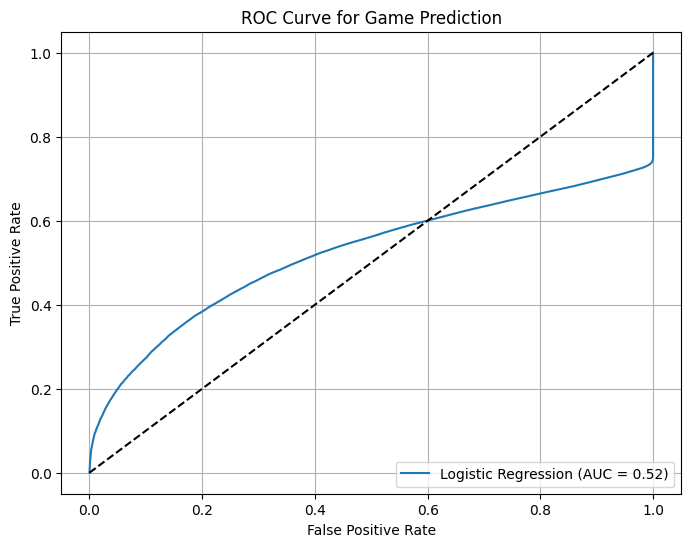

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# plotting

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Game Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve_base.png')

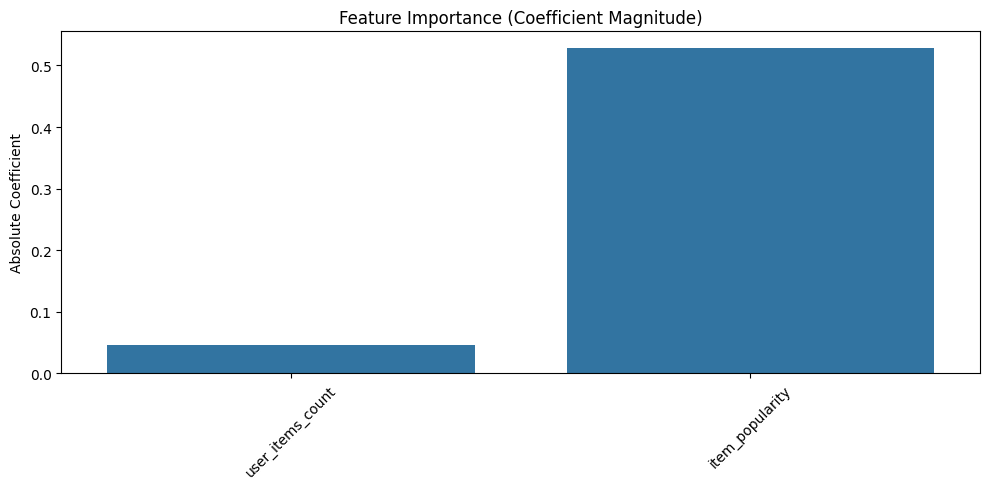

In [12]:
plt.figure(figsize=(10, 5))
sns.barplot(x=features, y=np.abs(model.coef_[0]))
plt.title('Feature Importance (Coefficient Magnitude)')
plt.ylabel('Absolute Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('feature_importance_base.png')

# Improved Model

In [13]:
MAX_TEXT_FEATURES = 500
MAX_TAG_FEATURES = 100
EMBEDDING_DIM = 32
BATCH_SIZE = 256
EPOCHS = 5

def smart_open(file_path, mode='rt', encoding='utf-8'):
    if os.path.exists(file_path):
        if file_path.endswith('.gz'):
            return gzip.open(file_path, mode=mode, encoding=encoding)
        return open(file_path, mode=mode, encoding=encoding)
    
    gz_path = file_path + '.gz'
    if os.path.exists(gz_path):
        return gzip.open(gz_path, mode=mode, encoding=encoding)
    return open(file_path, mode=mode, encoding=encoding)

def clean_text(text):
    if not text: return ""
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    return text

## Import Data

In [14]:
# Load User/Item Interactions
print("Loading interactions")
user_data = []
with smart_open('australian_users_items.json.gz') as f:
    for line in f:
        user_data.append(ast.literal_eval(line))

Loading interactions


In [15]:
# Load Game Metadata
print("Loading game metadata")
games_dict = {}
with smart_open('steam_games.json.gz') as f:
    for line in f:
        try:
            game = ast.literal_eval(line)
            gid = None
            if 'id' in game: gid = str(game['id'])
            elif 'app_id' in game: gid = str(game['app_id'])
            if not gid: continue
            
            # Extract Price
            price = game.get('price', 0)
            if isinstance(price, str):
                price = 0 if 'free' in price.lower() else float(price) if price.replace('.', '', 1).isdigit() else 0
            
            # Extract Tags
            tags = game.get('tags', []) + game.get('genres', [])
            tags_str = " ".join([t.lower() for t in tags])
            
            games_dict[gid] = {'price': price, 'tags': tags_str}
        except:
            continue

Loading game metadata


In [16]:
# Load Reviews
print("Loading reviews")
user_reviews_text = defaultdict(list)
with smart_open('steam_reviews.json.gz') as f:
    for line in f:
        try:
            node = ast.literal_eval(line)
            # Resolve ID
            uid = str(node.get('user_id', node.get('username', '')))
            if not uid: continue
            
            text = node.get('text', '')
            if text:
                user_reviews_text[uid].append(clean_text(text))
        except:
            continue

# Collapse reviews into single string per user
user_reviews_map = {uid: " ".join(texts) for uid, texts in user_reviews_text.items()}
del user_reviews_text
gc.collect()

Loading reviews


19272

In [17]:
print("df creation")

interactions = []
for user in user_data:
    uid = str(user['user_id'])
    for item in user['items']:
        interactions.append({
            'user_id': uid,
            'item_id': str(item['item_id']),
            'playtime': item['playtime_forever']
        })

df = pd.DataFrame(interactions)
del user_data, interactions
gc.collect()

# Filter only played games and existing games
df = df[df['playtime'] > 0]
df = df[df['item_id'].isin(games_dict.keys())]

df creation


## Feature Engineering

In [18]:
# Calculate popularity
pop_counts = df['item_id'].value_counts().to_dict()
df['popularity'] = df['item_id'].map(pop_counts)

In [19]:
# Negative sampling
print("Creating negative samples")
# Get list of all users and top 500 popular items
all_users = df['user_id'].unique()
top_items = list(df['item_id'].value_counts().head(500).index)

Creating negative samples


In [20]:
# Create a set of existing pairs for fast lookup
existing_pairs = set(zip(df['user_id'], df['item_id']))

n_positives = len(df)
target_negatives = n_positives

unique_users = df['user_id'].unique()
top_items_array = np.array(top_items)
existing_pairs = set(zip(df['user_id'], df['item_id']))

In [21]:
negative_rows = []

# Generate batches until we hit the target
while len(negative_rows) < target_negatives:
    needed = target_negatives - len(negative_rows)
    
    batch_size = int(needed * 1.2)
    
    batch_u = np.random.choice(unique_users, size=batch_size)
    batch_i = np.random.choice(top_items_array, size=batch_size)
    
    # Filter valid negatives
    for u, i in zip(batch_u, batch_i):
        if len(negative_rows) >= target_negatives:
            break
            
        if (u, i) not in existing_pairs:
            negative_rows.append({
                'user_id': u,
                'item_id': i,
                'playtime': 0,
                'popularity': pop_counts.get(i, 0)
            })
            # Add to existing_pairs to ensure we don't accidentally add the same negative twice
            existing_pairs.add((u, i))

df_neg = pd.DataFrame(negative_rows)
df_neg['target'] = 0
df['target'] = 1

In [22]:
# Merge Positive and Negative
full_df = pd.concat([df[['user_id', 'item_id', 'popularity', 'target']], 
                     df_neg[['user_id', 'item_id', 'popularity', 'target']]], ignore_index=True)

# Shuffle
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset Size: {len(full_df)} interactions")

Dataset Size: 5736110 interactions


In [23]:
print("Features")

# ID Encoding (Label Encoding)
print("Encoding IDs")
user_encoder = LabelEncoder()
full_df['user_idx'] = user_encoder.fit_transform(full_df['user_id'])
n_users = len(user_encoder.classes_)

item_encoder = LabelEncoder()
full_df['item_idx'] = item_encoder.fit_transform(full_df['item_id'])
n_items = len(item_encoder.classes_)

Features
Encoding IDs


In [24]:
# TF-IDF on User Reviews
print("Vectorizing reviews")
reviews_series = full_df['user_id'].map(lambda u: user_reviews_map.get(u, ""))
tfidf_rev = TfidfVectorizer(max_features=MAX_TEXT_FEATURES, stop_words='english', dtype=np.float32)
X_reviews = tfidf_rev.fit_transform(reviews_series).toarray().astype(np.float32)

# TF-IDF on Game Tags
print("Vectorizing game tags")
tags_series = full_df['item_id'].map(lambda i: games_dict.get(i, {}).get('tags', ""))
tfidf_tags = TfidfVectorizer(max_features=MAX_TAG_FEATURES, stop_words='english', dtype=np.float32)
X_tags = tfidf_tags.fit_transform(tags_series).toarray().astype(np.float32)

Vectorizing reviews
Vectorizing game tags


In [25]:
# Numerical Features (Price & Popularity)
print("Normalizing Numerical Features")
price_series = full_df['item_id'].map(lambda i: games_dict.get(i, {}).get('price', 0)).values.reshape(-1, 1)
pop_series = full_df['popularity'].values.reshape(-1, 1)

scaler = StandardScaler()
X_nums = scaler.fit_transform(np.hstack([price_series, pop_series])).astype(np.float32)

X_side = np.hstack([X_reviews, X_tags, X_nums])

print(f"Final Side Feature Dimension: {X_side.shape[1]}")

Normalizing Numerical Features
Final Side Feature Dimension: 602


## Model Training

In [26]:
# Clean up memory
del reviews_series, tags_series, X_reviews, X_tags, X_nums
gc.collect()

# Prepare inputs
X_u = full_df['user_idx'].values
X_i = full_df['item_idx'].values
y = full_df['target'].values

# Train/Test split
X_u_train, X_u_test, X_i_train, X_i_test, X_s_train, X_s_test, y_train, y_test = train_test_split(
    X_u, X_i, X_side, y, test_size=0.2, random_state=42
)

In [27]:
print("Generating model")

# Define inputs
user_input = layers.Input(shape=(1,), name='user_input')
item_input = layers.Input(shape=(1,), name='item_input')
side_input = layers.Input(shape=(X_side.shape[1],), name='side_input')

del X_side, X_u, X_i, y
del full_df
gc.collect()

Generating model


0

In [28]:
# Latent factor embeddings
u_emb = layers.Embedding(n_users, EMBEDDING_DIM, embeddings_regularizer=regularizers.l2(1e-5))(user_input)
i_emb = layers.Embedding(n_items, EMBEDDING_DIM, embeddings_regularizer=regularizers.l2(1e-5))(item_input)

u_vec = layers.Flatten()(u_emb)
i_vec = layers.Flatten()(i_emb)

mf_layer = layers.Dot(axes=1)([u_vec, i_vec])

dense_1 = layers.Dense(256, activation='relu')(side_input)
dense_1 = layers.Dropout(0.4)(dense_1)
dense_2 = layers.Dense(128, activation='relu')(dense_1)

In [29]:
# Include the raw user/item vectors in the deep path too, to learn non-linear interactions
concat = layers.Concatenate()([mf_layer, u_vec, i_vec, dense_2])

# Final prediction layer
pred_layer = layers.Dense(64, activation='relu')(concat)
output = layers.Dense(1, activation='sigmoid')(pred_layer)

In [30]:
model = Model(inputs=[user_input, item_input, side_input], outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision')]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ side_input          │ (None, 602)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 32)     │  2,172,608 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 32)     │    272,736 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    154,368 │ side_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 193)       │          0 │ dot[0][0],        │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     12,416 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,645,089 (10.09 MB)

 Trainable params: 2,645,089 (10.09 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
print("Training")

history = model.fit(
    [X_u_train, X_i_train, X_s_train],
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([X_u_test, X_i_test, X_s_test], y_test),
    verbose=1
)

print("Finished training")

Training
Epoch 1/5


2025-11-29 15:50:40.332733: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 11050042304 exceeds 10% of free system memory.


17926/17926 ━━━━━━━━━━━━━━━━━━━━ 292s 16ms/step - auc: 0.8644 - loss: 0.4668 - precision: 0.8001 - val_auc: 0.8995 - val_loss: 0.4287 - val_precision: 0.8247
Epoch 2/5
17926/17926 ━━━━━━━━━━━━━━━━━━━━ 288s 16ms/step - auc: 0.9111 - loss: 0.4178 - precision: 0.8338 - val_auc: 0.9143 - val_loss: 0.4231 - val_precision: 0.8373
Epoch 3/5
17926/17926 ━━━━━━━━━━━━━━━━━━━━ 284s 16ms/step - auc: 0.9300 - loss: 0.3985 - precision: 0.8553 - val_auc: 0.9171 - val_loss: 0.4270 - val_precision: 0.8343
Epoch 4/5
17926/17926 ━━━━━━━━━━━━━━━━━━━━ 283s 16ms/step - auc: 0.9373 - loss: 0.3890 - precision: 0.8647 - val_auc: 0.9179 - val_loss: 0.4290 - val_precision: 0.8428
Epoch 5/5
17926/17926 ━━━━━━━━━━━━━━━━━━━━ 283s 16ms/step - auc: 0.9399 - loss: 0.3849 - precision: 0.8685 - val_auc: 0.9180 - val_loss: 0.4300 - val_precision: 0.8454
Finished training


In [32]:
preds = model.predict([X_u_test, X_i_test, X_s_test], batch_size=BATCH_SIZE)
roc = roc_auc_score(y_test, preds)
pr = average_precision_score(y_test, preds)

print(f"ROC AUC: {roc:.4f}")
print(f"PR AUC:  {pr:.4f}")

4482/4482 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
ROC AUC: 0.9180
PR AUC:  0.9250


In [33]:
# Example Predictions
print("\nSample Predictions:")
for i in range(5):
    p = preds[i][0]
    actual = y_test[i]
    print(f"Predicted: {p:.4f} | Actual: {actual}")


Sample Predictions:
Predicted: 0.6199 | Actual: 0
Predicted: 0.0625 | Actual: 0
Predicted: 0.9535 | Actual: 1
Predicted: 0.7951 | Actual: 1
Predicted: 0.8379 | Actual: 1
